In [1]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from tensorflow.keras import Model # type: ignore
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TF warnings

# Model architecture and helpers

In [2]:
def build_conv_autoencoder(input_shape):
    """
    Build a 1D convolutional autoencoder with a bottleneck (latent space).
    Input shape should be (seq_len, n_features), e.g., (30, 15).
    """
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
        tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', name="latent_space"),  # Bottleneck latent space
        tf.keras.layers.Dense(np.prod(input_shape), activation='sigmoid'),
        tf.keras.layers.Reshape(input_shape)
    ])
    return model

In [3]:
def compute_loss(data, reconstructed_data, latent_representation, cluster_centers, assignments, alpha=0.5):
    """
    Compute the combined loss:
      L = α * L_{CL} + (1 - α) * L_{AE},
    where L_{AE} is the MSE reconstruction loss and L_{CL} the clustering loss.

    To handle multivariate time series (shape [batch, seq_len, n_features]),
    we sum squared errors over the last two axes.

    cluster_centers: an array of shape (num_clusters, latent_dim)
    assignments: an array of cluster assignment indices for each sample (batch size,)
    """
    # Reconstruction loss: mean squared error summed over time and features
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum( tf.square(data - reconstructed_data), axis=[1,2]))

    # Get the assignments for the current batch
    batch_assignments = tf.gather(assignments, tf.range(tf.shape(latent_representation)[0]))

    # Clustering loss: For each cluster, sum squared error between latent points and the cluster center.
    clustering_loss = 0.0
    num_clusters = cluster_centers.shape[0]
    for j in range(num_clusters):
        cluster_mask = tf.cast(tf.equal(batch_assignments, j), tf.float32)
        # Select latent representations that belong to cluster j
        cluster_points = tf.boolean_mask(latent_representation, cluster_mask)
        # Only include if there is at least one sample in the cluster
        if tf.size(cluster_points) > 0:
            diff = cluster_points - cluster_centers[j]
            loss_j = tf.reduce_sum(tf.square(diff))
            clustering_loss += loss_j / (tf.reduce_sum(cluster_mask) + 1e-8)

    combined_loss = alpha * clustering_loss + (1 - alpha) * reconstruction_loss
    return combined_loss

In [4]:
def compute_max_euclidean_distance(cluster_centers_1, cluster_centers_2):
    """
    Compute Equation (6): for each latent channel j,
      d_j = || m_no,j - m_ano,j ||_2,
    and return the maximum distance.
    Here, cluster_centers_1 and cluster_centers_2 are arrays with shape (num_clusters, latent_dim).
    """
    distances = np.linalg.norm(cluster_centers_1 - cluster_centers_2, axis=1)
    return np.max(distances)

In [5]:
def rank_channels(m_no, m_ano, top_k=10):
    """
    Rank the latent channels (each channel corresponds to one dimension in the latent space)
    by computing, for each channel j, the maximum absolute difference between
      m_no[:, j] and m_ano[:, j].
    Return the indices of the top_k channels with the highest differences.
    """
    # Compute absolute differences: shape (num_clusters, latent_dim)
    differences = np.abs(m_no - m_ano)
    # For each channel (latent dimension), take the maximum difference over clusters.
    channel_differences = np.max(differences, axis=0)
    # Get indices that would sort in descending order.
    sorted_indices = np.argsort(-channel_differences)
    return sorted_indices[:top_k]

# Training procedure

> Translated from [original paper](https://doi.org/10.54963/dtra.v1i2.64)

In [6]:
def train_autoencoder(x_all, P=5, N=20, C=3,
                      pretrain_alpha=0.0, train_alpha=0.5,
                      learning_rate=0.001, num_clusters=10,
                      top_k=10, batch_size=20,
                      runner_device='/CPU:0'):
    """
    x_all: training data as a NumPy array with shape (n_samples, seq_len, n_features).
    P: Number of pretraining epochs.
    N: Total number of epochs.
    C: Cluster update interval (in epochs).
    pretrain_alpha: α value during pretraining (reconstruction-only).
    train_alpha: α value during the second (fine tuning) phase.
    batch_size: batch size for training.
    """
    seq_len, n_features = x_all.shape[1:]

    # Create tf.data.Dataset for batching.
    dataset = tf.data.Dataset.from_tensor_slices(x_all).shuffle(1000).batch(batch_size)

    # Build and compile model.
    model = build_conv_autoencoder(input_shape=(seq_len, n_features))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # A secondary model to extract the latent representation:
    latent_model = Model(inputs=model.layers[0].input, outputs=model.get_layer("latent_space").output)

    # Dummy placeholders for clustering during pretraining:
    latent_dim = 64  # size of latent representation layer.
    dummy_cluster_centers = np.zeros((num_clusters, latent_dim), dtype=np.float32)
    dummy_assignments = np.zeros((batch_size,), dtype=np.int32)

    print("=== Pre-training Phase (Epochs 1 to P+1) ===")
    # Pre-training: update using only reconstruction loss (α=0)
    for epoch in range(1, P+2):
        epoch_loss = []
        for batch in dataset:
          with tf.device(runner_device):
            with tf.GradientTape() as tape:
                reconstructed = model(batch, training=True)
                latent_repr = latent_model(batch, training=True)
                # Use α = pretrain_alpha (here, 0) so clustering loss is ignored.
                loss = compute_loss(batch, reconstructed, latent_repr,
                                    cluster_centers=dummy_cluster_centers,
                                    assignments=dummy_assignments,
                                    alpha=pretrain_alpha)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss.numpy())
        print(f"Pre-train Epoch {epoch}/{P+1}  Loss: {np.mean(epoch_loss):.4f}")

        # At the final pre-training epoch, perform clustering.
        if epoch == P+1:
            # Obtain latent representations for all data.
            latent_all = latent_model.predict(x_all, batch_size=batch_size)
            kmeans = KMeans(n_clusters=num_clusters, n_init=10)
            kmeans.fit(latent_all)
            cluster_centers_curr = kmeans.cluster_centers_  # m_ano
            assignments_current = kmeans.labels_
            # For the purpose of ranking channels, initialize previous centers to current ones.
            cluster_centers_prev = cluster_centers_curr.copy()
            # Rank channels using Equation (6) to get top K:
            top_k_indices = rank_channels(cluster_centers_prev, cluster_centers_curr, top_k=top_k)
            print(f"After Pre-training: K-Means centers computed, top {top_k} channels (indices): {top_k_indices}")

    # -----------------------------
    # Fine-tuning Phase (Epochs P+2 to N)
    # -----------------------------
    print("\n=== Fine-tuning Phase (Epochs P+2 to N) ===")
    # Prepare variables for cluster centers & assignments used during training.
    current_cluster_centers = cluster_centers_curr  # m_ano from last pretrain
    current_assignments = assignments_current

    # For selective updates, extract the latent layer (named "latent_space")
    latent_layer = model.get_layer("latent_space")
    # Typically latent_layer.trainable_variables yields [kernel, bias]

    # Training loop for fine-tuning:
    for epoch in range(P+2, N+1):
        epoch_loss = []
        for batch in dataset:
          with tf.device(runner_device):
            # -----------------------------
            # First gradient update: update only the top K channels in the latent layer.
            with tf.GradientTape() as tape1:
                reconstructed = model(batch, training=True)
                latent_repr = latent_model(batch, training=True)
                loss = compute_loss(batch, reconstructed, latent_repr,
                                    cluster_centers=current_cluster_centers,
                                    assignments=current_assignments,
                                    alpha=train_alpha)
            grads1 = tape1.gradient(loss, model.trainable_variables)

            # Create masked gradients: only update latent layer top K channels.
            masked_grads1 = []
            for var, grad in zip(model.trainable_variables, grads1):
                # Check if this variable belongs to the latent layer.
                if var is latent_layer.weights[0]:
                    # latent_layer kernel: shape (input_dim, latent_dim)
                    mask = np.zeros(grad.shape[1], dtype=np.float32)
                    mask[top_k_indices] = 1.0
                    mask = tf.constant(mask, dtype=grad.dtype)
                    mask = tf.reshape(mask, (1, -1))  # broadcast over input dimension
                    masked_grad = grad * mask
                    masked_grads1.append(masked_grad)
                elif var is latent_layer.weights[1]:
                    # latent_layer bias: shape (latent_dim,)
                    mask = np.zeros(grad.shape[0], dtype=np.float32)
                    mask[top_k_indices] = 1.0
                    mask = tf.constant(mask, dtype=grad.dtype)
                    masked_grad = grad * mask
                    masked_grads1.append(masked_grad)
                else:
                    # Other parameters are not updated in this pass.
                    masked_grads1.append(tf.zeros_like(grad))

            optimizer.apply_gradients(zip(masked_grads1, model.trainable_variables))

            # -----------------------------
            # Second gradient update: update all parameters except for the top K channels in the latent layer.
            with tf.GradientTape() as tape2:
                reconstructed = model(batch, training=True)
                latent_repr = latent_model(batch, training=True)
                loss = compute_loss(batch, reconstructed, latent_repr,
                                    cluster_centers=current_cluster_centers,
                                    assignments=current_assignments,
                                    alpha=train_alpha)
            grads2 = tape2.gradient(loss, model.trainable_variables)

            masked_grads2 = []
            for var, grad in zip(model.trainable_variables, grads2):
                if var is latent_layer.weights[0]:
                    # For kernel, update only the channels NOT in top_k.
                    mask = np.ones(grad.shape[1], dtype=np.float32)
                    mask[top_k_indices] = 0.0
                    mask = tf.constant(mask, dtype=grad.dtype)
                    mask = tf.reshape(mask, (1, -1))
                    masked_grad = grad * mask
                    masked_grads2.append(masked_grad)
                elif var is latent_layer.weights[1]:
                    # For bias, update only the channels NOT in top_k.
                    mask = np.ones(grad.shape[0], dtype=np.float32)
                    mask[top_k_indices] = 0.0
                    mask = tf.constant(mask, dtype=grad.dtype)
                    masked_grad = grad * mask
                    masked_grads2.append(masked_grad)
                else:
                    # For all other variables, update normally.
                    masked_grads2.append(grad)

            optimizer.apply_gradients(zip(masked_grads2, model.trainable_variables))
            epoch_loss.append(loss.numpy())

        avg_epoch_loss = np.mean(epoch_loss)
        print(f"Fine-tune Epoch {epoch}/{N}  Loss: {avg_epoch_loss:.4f}")

        # Every C epochs, update clustering and re-rank channels.
        if epoch % C == 0:
            latent_all = latent_model.predict(x_all, batch_size=batch_size)
            kmeans = KMeans(n_clusters=num_clusters, n_init=10)
            kmeans.fit(latent_all)
            new_centers = kmeans.cluster_centers_
            new_assignments = kmeans.labels_
            # Update previous cluster centers
            cluster_centers_prev = current_cluster_centers.copy()
            current_cluster_centers = new_centers
            current_assignments = new_assignments
            top_k_indices = rank_channels(cluster_centers_prev, current_cluster_centers, top_k=top_k)
            max_euclidean = compute_max_euclidean_distance(cluster_centers_prev, current_cluster_centers)
            print(f"Epoch {epoch}: Updated K-Means centers. Top {top_k} channels: {top_k_indices}. Max Euclidean dist: {max_euclidean:.4f}")

    return model

In [7]:
from pandas import read_parquet, Series
from sklearn.preprocessing import MinMaxScaler

In [8]:
df_train = read_parquet('C:/Users/leo.logel/Workspace/IA/Prediction_compteurs_SDEA/ds-efficiency-target-ml/Data/train.gzip')
df_test = read_parquet('C:/Users/leo.logel/Workspace/IA/Prediction_compteurs_SDEA/ds-efficiency-target-ml/Data/test.gzip')

In [9]:
def scale_by_id(group):
    scaler = MinMaxScaler()
    group_values = group.values.reshape(-1, 1)
    scaled_values = scaler.fit_transform(group_values)
    return Series(scaled_values.ravel(), index=group.index)

df_train['vol_scaled'] = df_train.groupby('id').vol.transform(scale_by_id)
df_test['vol_scaled'] = df_test.groupby('id').vol.transform(scale_by_id)

In [10]:
def create_sequences(df, seq_len):
    """
    Generates sequences of length seq_len from the DataFrame.

    Args:
      df: The input DataFrame.
      seq_len: The desired sequence length.

    Returns:
      A NumPy array of shape (num_sequences, seq_len, num_features).
    """
    data = df.values  # Convert DataFrame to NumPy array
    num_sequences = data.shape[0] - seq_len + 1
    sequences = np.zeros((num_sequences, seq_len, data.shape[1]))
    for i in range(num_sequences):
      sequences[i] = np.array(data[i : i + seq_len])
    return np.array(sequences).astype(np.float32)

In [11]:
gpus = tf.config.list_physical_devices('GPU')
device = '/GPU:0' if gpus else '/CPU:0'

In [21]:
print(f"Using device: {device}")

Using device: /GPU:0


In [ ]:
# Parameters for multivariate time series:
seq_len = 30          # length of each sequence
n_samples = 200       # total number of sequences
n_features = 15       # number of features per time step
x_all = create_sequences(df_train[['vol_scaled']], seq_len) # np.random.rand(n_samples, seq_len, n_features).astype(np.float32)

# Training parameters:
P = 25         # pre-training epochs
N = 50        # total epochs
C = 3         # cluster update interval
pretrain_alpha = 0.0   # use reconstruction-only loss during pre-training
train_alpha = 0.5      # combined loss weight during fine-tuning
learning_rate = 0.1
num_clusters = 4
top_k = 10
batch_size = 1024

# Train the autoencoder:
trained_model = train_autoencoder(x_all, P=P, N=N, C=C,
                                pretrain_alpha=pretrain_alpha,
                                train_alpha=train_alpha,
                                learning_rate=learning_rate,
                                num_clusters=num_clusters,
                                top_k=top_k,
                                batch_size=batch_size,
                                runner_device=device)

=== Pre-training Phase (Epochs 1 to P+1) ===
Pre-train Epoch 1/36  Loss: 1.0802
Pre-train Epoch 2/36  Loss: 0.2238
Pre-train Epoch 3/36  Loss: 0.0756
Pre-train Epoch 4/36  Loss: 0.0478
Pre-train Epoch 5/36  Loss: 0.0421
Pre-train Epoch 6/36  Loss: 0.0372
Pre-train Epoch 7/36  Loss: 0.0344
Pre-train Epoch 8/36  Loss: 0.0318
Pre-train Epoch 9/36  Loss: 0.0306
Pre-train Epoch 10/36  Loss: 0.0291
Pre-train Epoch 11/36  Loss: 0.0275
Pre-train Epoch 12/36  Loss: 0.0266
Pre-train Epoch 13/36  Loss: 0.0253
Pre-train Epoch 14/36  Loss: 0.0247
Pre-train Epoch 15/36  Loss: 0.0238
Pre-train Epoch 16/36  Loss: 0.0232
Pre-train Epoch 17/36  Loss: 0.0226
Pre-train Epoch 18/36  Loss: 0.0220
Pre-train Epoch 19/36  Loss: 0.0213
Pre-train Epoch 20/36  Loss: 0.0208
Pre-train Epoch 21/36  Loss: 0.0203
Pre-train Epoch 22/36  Loss: 0.0197
Pre-train Epoch 23/36  Loss: 0.0197
Pre-train Epoch 24/36  Loss: 0.0191
Pre-train Epoch 25/36  Loss: 0.0189
Pre-train Epoch 26/36  Loss: 0.0182
Pre-train Epoch 27/36  Loss:

# Visualize results

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [14]:
def visualize_reconstruction(model, x_test, num_samples=5):
    """
    Visualizes the reconstruction of the input data by the autoencoder.

    Args:
        model: The trained autoencoder model.
        x_test: The test data.
        num_samples: The number of samples to visualize.
    """
    # Select a few samples from the test data
    sample_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
    samples = x_test[sample_indices]

    # Reconstruct the samples using the model
    reconstructed_samples = model.predict(samples)

    # Plot the original and reconstructed samples
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))
    for i in range(num_samples):
        # Plot the original sample
        axes[i, 0].plot(samples[i])
        axes[i, 0].set_title(f"Original Sample {i + 1}")

        # Plot the reconstructed sample
        axes[i, 1].plot(reconstructed_samples[i])
        axes[i, 1].set_title(f"Reconstructed Sample {i + 1}")

    plt.tight_layout()
    plt.show()

In [15]:
def visualize_latent_space(latent_model, x_test, assignments):
    """
    Visualizes the clustering of the data in the latent space using t-SNE.

    Args:
        latent_model: The model to extract the latent representation.
        x_test: The test data.
        assignments: Cluster assignments for the test data.
    """
    # Extract the latent representation of the test data
    latent_repr = latent_model.predict(x_test)

    # Reduce the dimensionality of the latent representation using t-SNE
    reducer = PCA(n_components=2, random_state=42)
    # reducer = TSNE(n_components=2, random_state=42, perplexity=min(x_test.shape[0]-1, 30))
    latent_repr_red = reducer.fit_transform(latent_repr)

    # Plot the latent representation with cluster assignments
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_repr_red[:, 0], latent_repr_red[:, 1], c=assignments, cmap='viridis')
    plt.title("Latent Space Visualization (t-SNE)")
    plt.colorbar(label="Cluster Assignment")
    plt.show()

In [26]:
# Assuming you have trained_model and latent_model from the previous code
# and x_test is your test data with assignments from KMeans:
test_seqs = create_sequences(df_test[['vol_scaled']], seq_len)[:1000]
dataset = tf.data.Dataset.from_tensor_slices(test_seqs).shuffle(1000).batch(batch_size)
x_test = dataset.as_numpy_iterator().next()

1/1 [==============================] - 0s 17ms/step


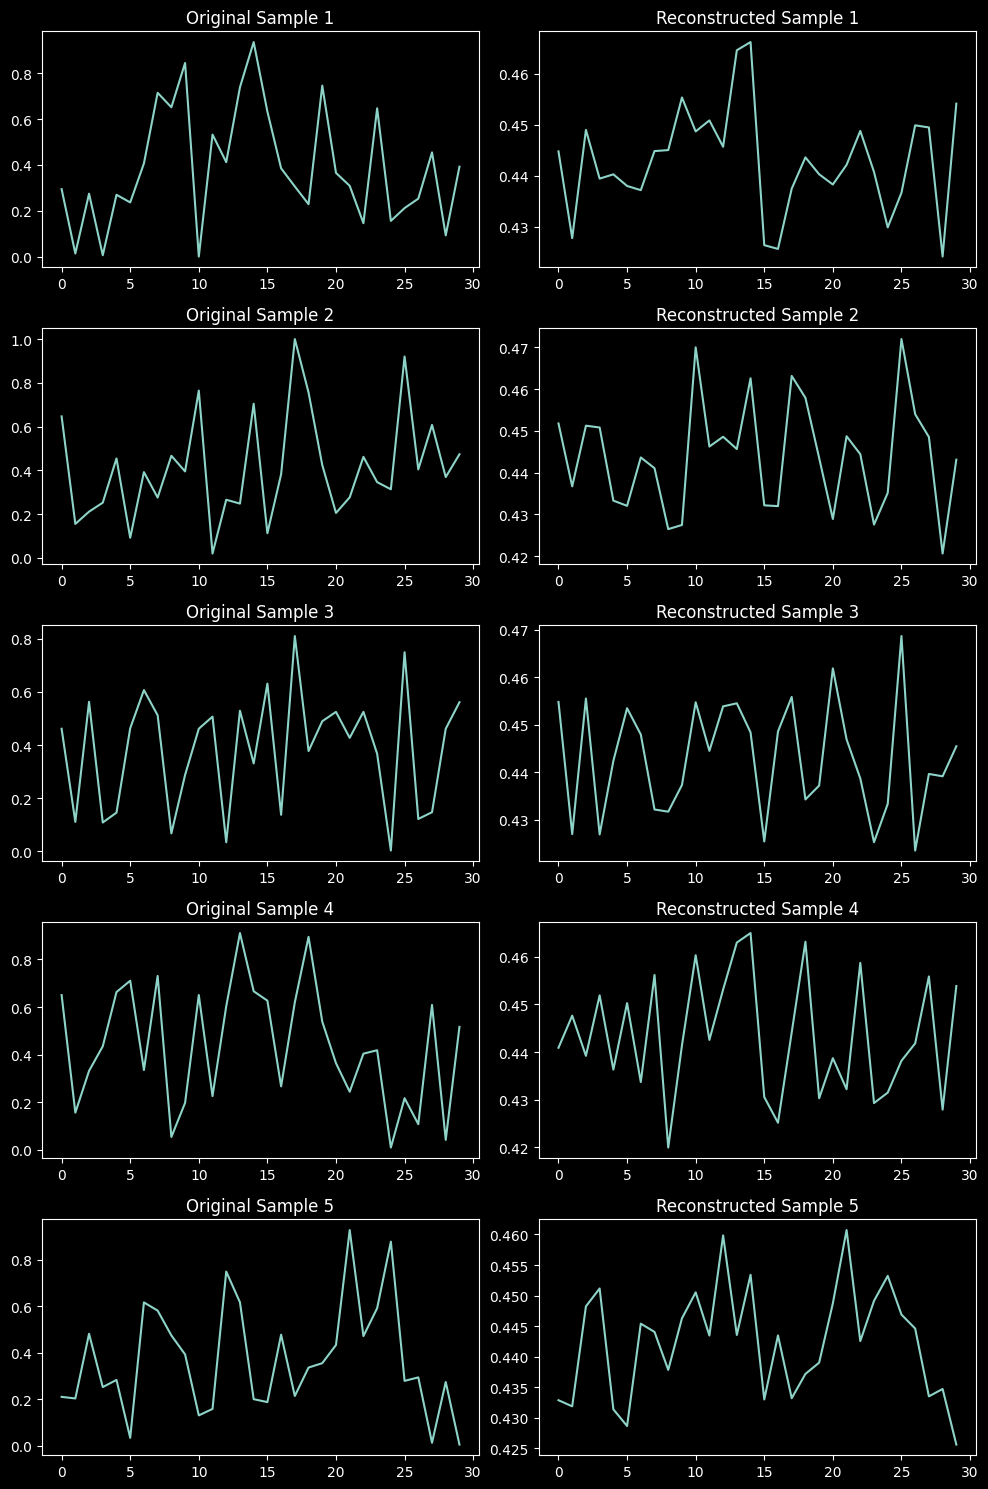

In [27]:
# Visualize reconstruction:
visualize_reconstruction(trained_model, x_test)

In [28]:
latent_model = Model(inputs=trained_model.layers[0].input, outputs=trained_model.get_layer("latent_space").output)

latent_repr = latent_model.predict(test_seqs, batch_size=batch_size)

kmeans = KMeans(n_clusters=num_clusters, n_init=10)
kmeans.fit(latent_repr)
centers = kmeans.cluster_centers_
assignments = kmeans.labels_

# Reduce the dimensionality of the latent representation (2D for vizualisation)
tsne = TSNE(n_components=2, random_state=42, perplexity=min(x_test.shape[0]-1, 30))
latent_repr_tsne = tsne.fit_transform(latent_repr)

# Choose example for resulting clustering
sample_index = np.random.choice(test_seqs.shape[0]-seq_len, 1, replace=False)[0]
sample = test_seqs[sample_index:sample_index+seq_len]
sample_assignments = kmeans.predict(latent_repr[sample_index:sample_index+seq_len])

1/1 [==============================] - 0s 446ms/step


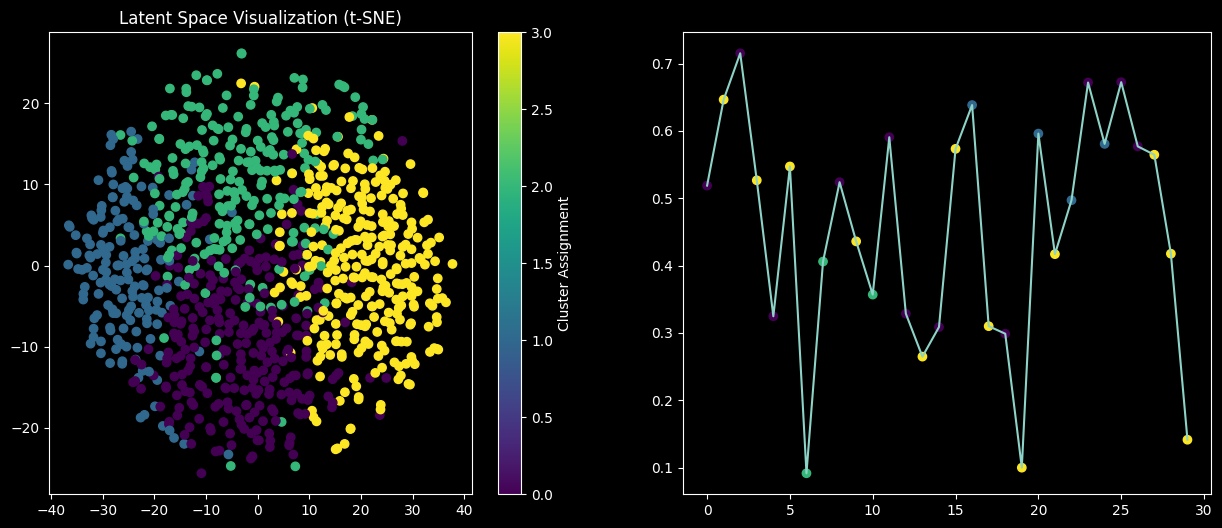

In [29]:
# Plot the latent representation with cluster assignments
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.scatter(latent_repr_tsne[:, 0], latent_repr_tsne[:, 1], c=assignments, cmap='viridis')
plt.title("Latent Space Visualization (t-SNE)")
plt.colorbar(label="Cluster Assignment")

plt.subplot(1,2,2)
plt.plot(sample[:,-1,:])
plt.scatter(range(len(sample)), sample[:,-1,:], c=sample_assignments)
plt.show()